# Исследовательский проект по ResNet

В данном исследовательском проекте мы планируем разработать и обучить нейросеть с использованием архитектуры ResNet для определения возраста человека по фотографии. Мы не только собираемся создать ResNet с нуля, но мы также сравним ее производительность с "коробочной" версией ResNet-34, доступной в PyTorch. Цель состоит в том, чтобы понять, как созданная с нуля модель справляется с задачей в сравнении с "коробочной" версией и с её версией предварительно обученной модели, и также попытаться определить, можно ли улучшить производительность нашей модели путем настройки и оптимизации.

Для достижения этой цели мы будем проводить работу в несколько этапов, включая подготовку и предобработку данных, построение и обучение модели, тестирование модели и сравнение ее производительности с ResNet50, а также изучение возможных способов улучшения модели.

План работы:
- Подготовка и предобработка датасета
- Создание нейросети ResNet с нуля
- Создание и обучение "коробочной" версии ResNet-34
- Создание предобученной ResNet-34
- Сравнение моделей
- Предложение о возможных улучшениях и дальнейших шагах

## Подготовка и предобработка датасета

Для начала произведём импорт необходимых библиотек.

In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
import os

Зададим стартовое число для генератора случайных чисел в PyTorch, для воспроизводимости результатов. Однако, полная воспроизводимость может быть не гарантирована на разных платформах, версиях PyTorch и при использовании GPU.

In [2]:
torch.manual_seed(13)

Мы будем использовать датасет APPA-REAL, доступный по ссылке https://chalearnlap.cvc.uab.cat/dataset/26/description/. В нём содержится 7591 изображение, которые разделены на 4113 обучающих, 1500 валидационных и 1978 тестовых. В датасете каждому изображению соответствуют метки реального и видимого возрастов. Для упрощения мы будем использовать только метки реального возраста, это будет наш таргет - его мы будем предсказывать.

In [3]:
train_labels = pd.read_csv('H:/python/ResNet/dataset/appa-real-release/gt_avg_train.csv')
valid_labels = pd.read_csv('H:/python/ResNet/dataset/appa-real-release/gt_avg_valid.csv')
test_labels = pd.read_csv('H:/python/ResNet/dataset/appa-real-release/gt_avg_test.csv')
data_labels = [train_labels, valid_labels, test_labels]

Выделим названия изображений и соответствующие им метки реального возраста.

In [4]:
for idx, data in enumerate(data_labels):
    data = data[['file_name', 'real_age']]
    data_labels[idx] = data

train_labels, valid_labels, test_labels = data_labels

Как пример выведем метки обучающей выборки.

In [5]:
train_labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
4108,004108.jpg,41
4109,004109.jpg,53
4110,004110.jpg,35
4111,004111.jpg,28


Далее подробнее взглянем на метки из наших выборок, посмотрим их распределение по возрастам.

In [6]:
for data in data_labels:
    print(data.info())
    print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4113 non-null   object
 1   real_age   4113 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB
None
          real_age
count  4113.000000
mean     30.476052
std      16.312428
min       1.000000
25%      19.000000
50%      28.000000
75%      40.000000
max     100.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1500 non-null   object
 1   real_age   1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.6+ KB
None
          real_age
count  1500.000000
mean     30.473333
std      16.243189
min       1.000000
25%      19.000000
50%      28.000000
75%      40.000000
max      90.000000
<class 'pandas.core.fr

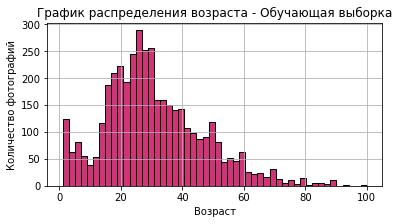

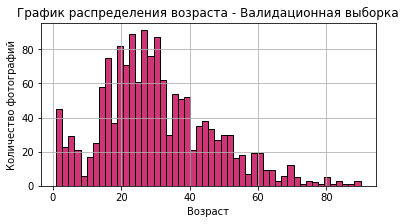

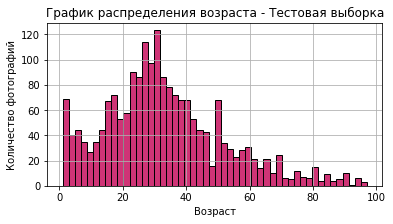

In [7]:
data_names = ['Обучающая выборка', 'Валидационная выборка', 'Тестовая выборка']
for idx, data in enumerate(data_labels):
    plt.figure(figsize=(6, 3))
    plt.hist(
        data['real_age'],
        bins=50,
        color="#CF3476",
        ec="black"
    )
    plt.title(f'График распределения возраста - {data_names[idx]}')
    plt.xlabel('Возраст')
    plt.ylabel('Количество фотографий')
    plt.grid(True)
    plt.show();

В целом распределения целевого признака в тренировочной, валидационной и тестовой выборках схожи. Это говорит о том, что разделение данных выполнено корректно, и модель сможет успешно обучаться и предсказывать результаты.

Выведем первые 12 изображений из тренировочного набора данных вместе с их метками возраста.

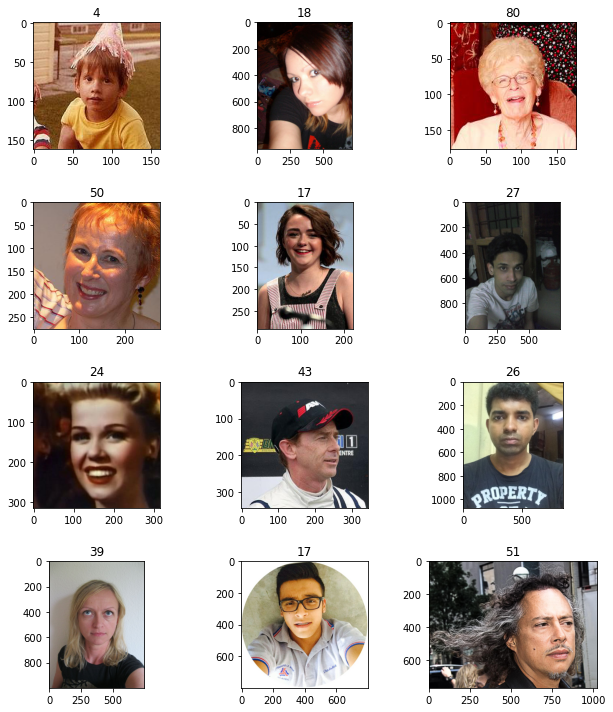

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(Image.open('H:/python/ResNet/dataset/appa-real-release/train/'+ train_labels['file_name'][i]))
    plt.title(train_labels['real_age'][i])
    fig.tight_layout(h_pad=2)

Для каждого изображения X.jpg также предоставляется соответствующее изображение X.jpg_face.jpg, которое содержит обрезанное и повернутое лицо, полученное с помощью детектора лиц Mathias при различных углах поворота. 

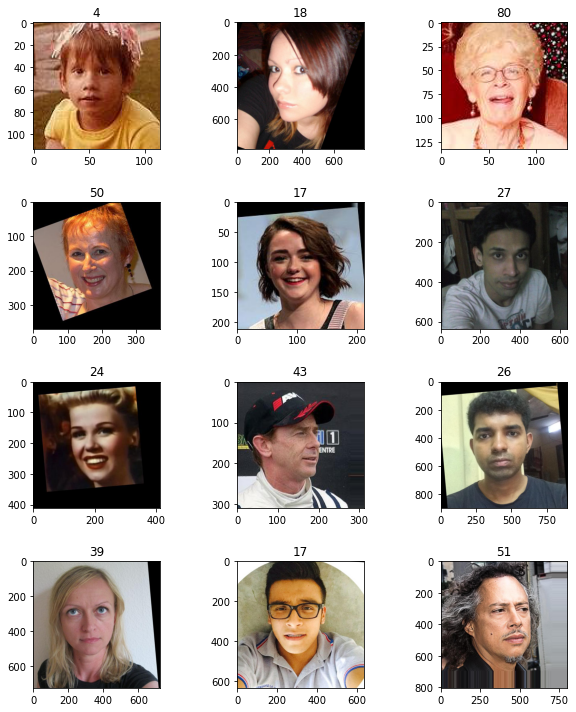

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(Image.open('H:/python/ResNet/dataset/appa-real-release/train/'+ train_labels['file_name'][i] + '_face.jpg'))
    plt.title(train_labels['real_age'][i])
    fig.tight_layout(h_pad=2)

Сфокусируемся только на данных, которые были обработаны. Создадим класс загрузки датасета.

In [10]:
class AgePredictionDataset(Dataset):
    # инициализируем класс, укажем путь к файлам изображений и файлы с метками
    def __init__(self, image_dir, labels_dataframe, transform=None):
        self.image_dir = image_dir
        self.labels_dataframe = labels_dataframe
        self.transform = transform

    def __len__(self):
        return len(self.labels_dataframe)

    def __getitem__(self, idx):
        # формируем имя файла с суффиксом ".jpg_face"
        img_name = os.path.join(self.image_dir, self.labels_dataframe.iloc[idx, 0].replace(".jpg", ".jpg_face.jpg"))
        
        # если изображение не найдено, попробуем использовать изображение без ".jpg_face"
        if not os.path.exists(img_name):
            img_name = os.path.join(self.image_dir, self.labels_dataframe.iloc[idx, 0])

        image = Image.open(img_name).convert('RGB')
        labels = torch.tensor(self.labels_dataframe.iloc[idx, 1], dtype=torch.float)
        
        if self.transform:
            image = self.transform(image)

        return image, labels

Преобразования данных сделаем такое же, какое было произведено при обучении на ImageNet. Данные можно посмотреть тут - https://pytorch.org/hub/pytorch_vision_resnet/. Для моделей обучаемых с нуля это не принципиально, а для предобученной модели важно.

In [11]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dir_train = 'H:/python/ResNet/dataset/appa-real-release/train/'
image_dir_valid = 'H:/python/ResNet/dataset/appa-real-release/valid/'
image_dir_test = 'H:/python/ResNet/dataset/appa-real-release/test/'

dataset_train = AgePredictionDataset(image_dir_train, train_labels, transform=transform)
dataset_valid = AgePredictionDataset(image_dir_valid, valid_labels, transform=transform)
dataset_test = AgePredictionDataset(image_dir_test, test_labels, transform=transform)

Проверим работу класса датасета.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label(возраст): 4.0
Image shape: torch.Size([3, 224, 224])


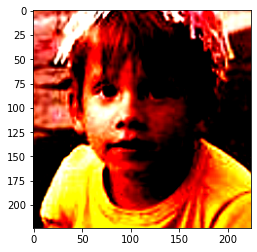

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label(возраст): 18.0
Image shape: torch.Size([3, 224, 224])


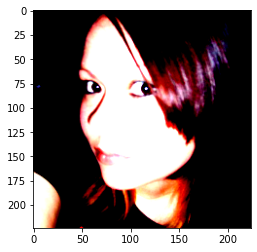

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label(возраст): 80.0
Image shape: torch.Size([3, 224, 224])


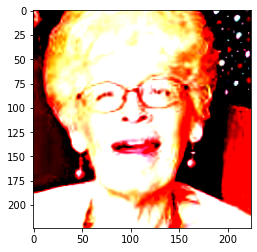

In [12]:
for i in range(3):
    image, label = dataset_train[i]
    print(f'Label(возраст): {label}')
    print(f'Image shape: {image.shape}')
    plt.imshow(image.numpy().transpose((1, 2, 0))) # перестановка CHW -> HWC
    plt.show()

Создадим загрузчик данных DataLoader.

In [13]:
batch_size = 64
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Проверим работу загрузчика.

In [14]:
for images, labels in train_loader:
    print(f'Batch size: {len(images)}')
    print(f'Images shape: {images.shape}')
    print(f'Labels shape: {labels.shape}')
    break  # выведем информацию для батча

Batch size: 64
Images shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


## Создание модели с нуля.

Переходим к созданию модели с нуля на основе ResNet. За образец возьмём модель ResNet-34, схема которой представлена в статье https://arxiv.org/abs/1512.03385.

<img src="residual_network_resnet.png" alt="ResNet" width="1000"/>

Для начала создадим базовый блок, который повторяется по всей модели.

In [15]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample=downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)))

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out

Переходим к написанию самой модели.

In [16]:
class ResidualNetwork(nn.Module):
    def __init__(self, block, layers):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, 1)

    def _make_layer(self, block, channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, channels, 1, stride, bias=False),
                nn.BatchNorm2d(channels)
            )

        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, self.in_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)

        out = self.layer0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.fc(out)

        return out

В структуре модели можно выделить определённые секции: каждая последующая секция удваивает количество каналов. В кажой такой секции блоков мы видим разное количество базовых блоков для ResNet-34, исходя из схемы: 3 фиолетовых, 4 зелёных, 6 красных, 3 голубых - мы получаем 3-4-6-3.

In [17]:
model = ResidualNetwork(BasicBlock, [3, 4, 6, 3])
criterion = nn.MSELoss()
mae = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [18]:
# список для сохранения значений потерь
loss_values_my_rnn = []

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Эпоха {epoch+1} / {num_epochs}')
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    # для каждого батча
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        # обнуление градиентов
        optimizer.zero_grad()
        # прямой проход
        outputs = model(images)
        # изменение размерности меток
        labels = labels.unsqueeze(1)
        # вычисление потерь
        loss = criterion(outputs, labels)
        # обратный проход (вычисление градиентов)
        loss.backward()
        # обновление параметров модели на основе градиентов
        optimizer.step()

        # обновление прогресса
        running_loss += loss.item()
        pbar.set_description(f"Loss: {running_loss/(i+1)}")

        # сохраняем значение потери в список
        loss_values_my_rnn.append(running_loss/(i+1))

    
    # завершение прогресса для текущей эпохи
    pbar.close()

Эпоха 1 / 5


Loss: 387.5021446814904: 100%|██████████| 65/65 [45:24<00:00, 41.91s/it] 


Эпоха 2 / 5


Loss: 258.7534405048077: 100%|██████████| 65/65 [45:20<00:00, 41.85s/it] 


Эпоха 3 / 5


Loss: 257.2655555138221: 100%|██████████| 65/65 [45:18<00:00, 41.83s/it] 


Эпоха 4 / 5


Loss: 247.63869159405047: 100%|██████████| 65/65 [45:16<00:00, 41.80s/it]


Эпоха 5 / 5


Loss: 242.53522597092848: 100%|██████████| 65/65 [45:20<00:00, 41.86s/it]


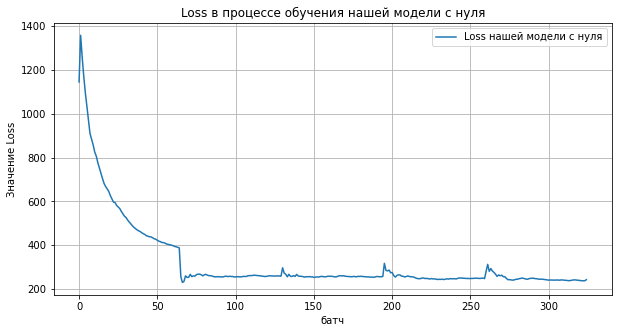

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values_my_rnn, label='Loss нашей модели с нуля')
plt.title('Loss в процессе обучения нашей модели с нуля')
plt.xlabel('батч')
plt.ylabel('Значение Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
model.eval()  # переводим модель в режим оценки

with torch.no_grad():  # отключаем вычисление градиентов
    mae_valid_my_rnn = []
    total_mae = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        # рассчитываем MAE
        mae_val = mae(outputs, labels)
        mae_valid_my_rnn.append(mae_val.item())
        total_mae += mae_val.item()

    average_mae = total_mae / len(valid_loader)
    print(f"MAE нашей модели с нуля на валидационной выборке: {average_mae}")

MAE нашей модели с нуля на валидационной выборке: 12.039342681566874


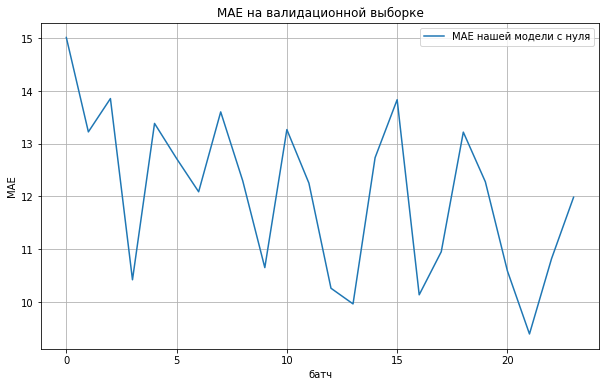

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(mae_valid_my_rnn, label='MAE нашей модели с нуля')
plt.title('MAE на валидационной выборке')
plt.xlabel('батч')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()

## Создание ResNet-34

Рассмотрим модель ResNet-34 https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html<br/>
если сравнить её код https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet34<br/>
с нашей моделью можно заметить некоторые общие черты. Но стоит отметить, что "коробочная" версия значительно сложнее. В ней реализованы более сложные и продвинутые функции и механизмы обучения, которые, вероятно, помогут достичь более высокого качества модели.

In [22]:
model_rs34 = torchvision.models.resnet.resnet34()

In [23]:
model_rs34.fc

Linear(in_features=512, out_features=1000, bias=True)

Изменим последний слой для вывода возраста.

In [24]:
model_rs34.fc = nn.Linear(model_rs34.fc.in_features, 1)

In [25]:
model_rs34.fc

Linear(in_features=512, out_features=1, bias=True)

In [26]:
optimizer_rs34 = torch.optim.Adam(model_rs34.parameters(), lr=0.001)
model_rs34 = model_rs34.to(device)

In [27]:
# список для сохранения значений потерь
loss_values_rs34 = []

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Эпоха {epoch+1} / {num_epochs}')
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    # для каждого батча
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        # обнуление градиентов
        optimizer_rs34.zero_grad()
        # прямой проход
        outputs = model_rs34(images)
        # изменение размерности меток
        labels = labels.unsqueeze(1)
        # вычисление потерь
        loss = criterion(outputs, labels)
        # обратный проход (вычисление градиентов)
        loss.backward()
        # обновление параметров модели на основе градиентов
        optimizer_rs34.step()

        # обновление прогресса
        running_loss += loss.item()
        pbar.set_description(f"Loss: {running_loss/(i+1)}")

        # сохраняем значение потери в список
        loss_values_rs34.append(running_loss/(i+1))

    
    # завершение прогресса для текущей эпохи
    pbar.close()

Эпоха 1 / 5


Loss: 397.9687746488131: 100%|██████████| 65/65 [48:02<00:00, 44.35s/it] 


Эпоха 2 / 5


Loss: 258.06314556415265: 100%|██████████| 65/65 [48:06<00:00, 44.41s/it]


Эпоха 3 / 5


Loss: 251.46931551419772: 100%|██████████| 65/65 [46:35<00:00, 43.00s/it]


Эпоха 4 / 5


Loss: 244.6929696890024: 100%|██████████| 65/65 [47:15<00:00, 43.62s/it] 


Эпоха 5 / 5


Loss: 231.21708749624398: 100%|██████████| 65/65 [46:01<00:00, 42.48s/it]


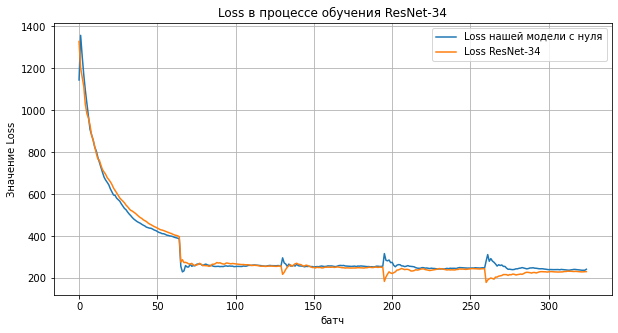

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values_my_rnn, label='Loss нашей модели с нуля')
plt.plot(loss_values_rs34, label='Loss ResNet-34')
plt.title('Loss в процессе обучения ResNet-34')
plt.xlabel('батч')
plt.ylabel('Значение Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
model_rs34.eval()

with torch.no_grad():
    mae_valid_rs34 = []
    total_mae = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model_rs34(images)
        # рассчитываем MAE
        mae_val = mae(outputs, labels)
        mae_valid_rs34.append(mae_val.item())
        total_mae += mae_val.item()

    average_mae = total_mae / len(valid_loader)
    print(f"MAE ResNet-34 на валидационной выборке: {average_mae}")

MAE ResNet-34 на валидационной выборке: 12.271724979082743


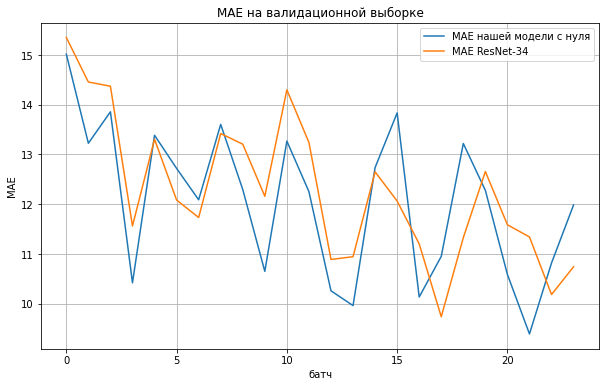

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(mae_valid_my_rnn, label='MAE нашей модели с нуля')
plt.plot(mae_valid_rs34, label='MAE ResNet-34')
plt.title('MAE на валидационной выборке')
plt.xlabel('батч')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()

Результаты вышли довольно схожими: как в процессе обучения с нуля, так и поведении на валидации. Примечательно, что количество обучаемых параметров в нашей модели и в 'коробочной' версии не отличается.

In [32]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

21285185

In [33]:
sum(p.numel() for p in model_rs34.parameters() if p.requires_grad)

21285185

## Создание предобученной ResNet-34

Здесь мы будем использовать предобученную ResNet-34 на данных ImageNet. https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html#torchvision.models.ResNet34_Weights

In [34]:
model_pretrained = torchvision.models.resnet.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)

Снова изменим последний слой для вывода возраста.

In [35]:
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, 1)
model_pretrained.fc

Linear(in_features=512, out_features=1, bias=True)

In [36]:
optimizer_pt = torch.optim.Adam(model_pretrained.parameters(), lr=0.001)
model_pretrained = model_pretrained.to(device)

In [37]:
# список для сохранения значений потерь
loss_values_pt = []

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Эпоха {epoch+1} / {num_epochs}')
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer_pt.zero_grad()
        outputs = model_pretrained(images)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pt.step()

        # обновление прогресса
        running_loss += loss.item()
        pbar.set_description(f"Loss: {running_loss/(i+1)}")

        # сохраняем значение потери в список
        loss_values_pt.append(running_loss/(i+1))
    
    # завершение прогресса для текущей эпохи
    pbar.close()

Эпоха 1 / 5


Loss: 337.75708559476413: 100%|██████████| 65/65 [46:22<00:00, 42.81s/it]


Эпоха 2 / 5


Loss: 107.866115628756: 100%|██████████| 65/65 [45:19<00:00, 41.84s/it]  


Эпоха 3 / 5


Loss: 79.60590233435998: 100%|██████████| 65/65 [45:06<00:00, 41.64s/it]


Эпоха 4 / 5


Loss: 58.16498283973107: 100%|██████████| 65/65 [46:21<00:00, 42.80s/it] 


Эпоха 5 / 5


Loss: 45.11063056358924: 100%|██████████| 65/65 [44:59<00:00, 41.54s/it] 


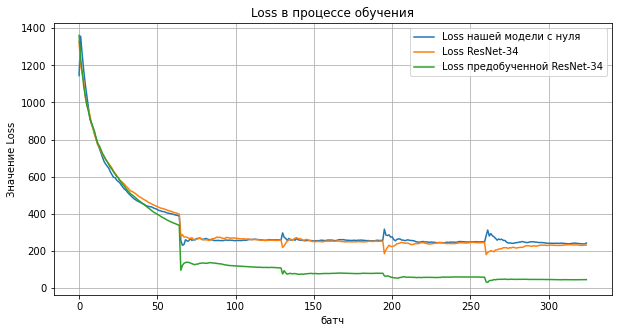

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values_my_rnn, label='Loss нашей модели с нуля')
plt.plot(loss_values_rs34, label='Loss ResNet-34')
plt.plot(loss_values_pt, label='Loss предобученной ResNet-34')
plt.title('Loss в процессе обучения')
plt.xlabel('батч')
plt.ylabel('Значение Loss')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
model_pretrained.eval()

with torch.no_grad():
    mae_valid_pt = []
    total_mae = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model_pretrained(images)

        mae_val = mae(outputs, labels)
        mae_valid_pt.append(mae_val.item())
        total_mae += mae_val.item()

    average_mae = total_mae / len(valid_loader)
    print(f"MAE предобученной ResNet-34 на валидационной выборке: {average_mae}")

MAE предобученной ResNet-34 на валидационной выборке: 8.086165964603424


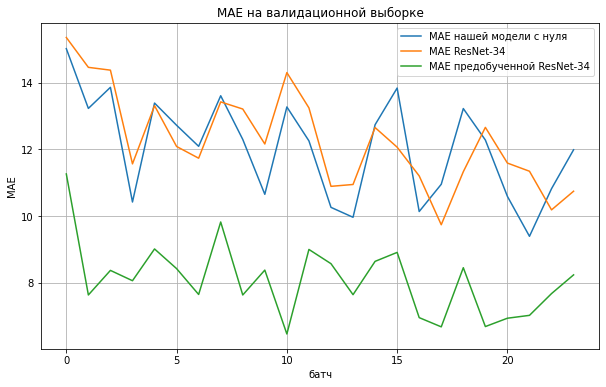

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(mae_valid_my_rnn, label='MAE нашей модели с нуля')
plt.plot(mae_valid_rs34, label='MAE ResNet-34')
plt.plot(mae_valid_pt, label='MAE предобученной ResNet-34')
plt.title('MAE на валидационной выборке')
plt.xlabel('батч')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()

Исходя из проведенных экспериментов, мы можем сделать следующие выводы:

- Модель, обученная с нуля (наша первоначальная модель), показала результат MAE 12.04 на валидационной выборке. Это демонстрирует возможности модели, обученной без использования предварительных весов, на ограниченном наборе данных.

- ResNet-34, обученная с нуля, показала результат MAE 12.27, что немного хуже нашей первоначальной модели. Это может быть обусловлено различием в архитектурах моделей или особенностями наших данных.

- Предобученная модель ResNet-34 значительно превзошла обе предыдущие модели, показав MAE 8.09. Это подтверждает гипотезу о преимуществах использования предобученных моделей при работе с ограниченным количеством данных.

Теперь нашей задачей будет доработка модели, обученной с нуля. Мы попробуем улучшить её показатели, экспериментируя с различными гиперпараметрами модели. Возможно, это позволит нам поднять качество нашей модели и приблизиться к результатам предобученной ResNet-34.

## Улучшение модели

Попробуем улучшить нашу модель, созданную с нуля.

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
# список для сохранения значений потерь
loss_values_my_rnn_1 = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Эпоха {epoch+1} / {num_epochs}')
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # обновление прогресса
        running_loss += loss.item()
        pbar.set_description(f"Loss: {running_loss/(i+1)}")

        # сохраняем значение потери в список
        loss_values_my_rnn_1.append(running_loss/(i+1))

    
    # завершение прогресса для текущей эпохи
    pbar.close()

Эпоха 1 / 10


Loss: 246.34471365121695: 100%|██████████| 65/65 [46:44<00:00, 43.14s/it]


Эпоха 2 / 10


Loss: 243.08103496844953: 100%|██████████| 65/65 [47:08<00:00, 43.51s/it]


Эпоха 3 / 10


Loss: 239.57518169696513: 100%|██████████| 65/65 [46:01<00:00, 42.49s/it]


Эпоха 4 / 10


Loss: 234.9384514441857: 100%|██████████| 65/65 [45:25<00:00, 41.93s/it] 


Эпоха 5 / 10


Loss: 232.6787069467398: 100%|██████████| 65/65 [45:37<00:00, 42.11s/it] 


Эпоха 6 / 10


Loss: 232.15804114708533: 100%|██████████| 65/65 [46:10<00:00, 42.63s/it]


Эпоха 7 / 10


Loss: 231.874146094689: 100%|██████████| 65/65 [45:49<00:00, 42.31s/it]  


Эпоха 8 / 10


Loss: 225.0153609055739: 100%|██████████| 65/65 [45:06<00:00, 41.63s/it] 


Эпоха 9 / 10


Loss: 219.13482548640326: 100%|██████████| 65/65 [44:59<00:00, 41.53s/it]


Эпоха 10 / 10


Loss: 215.47342670147236: 100%|██████████| 65/65 [45:00<00:00, 41.55s/it]


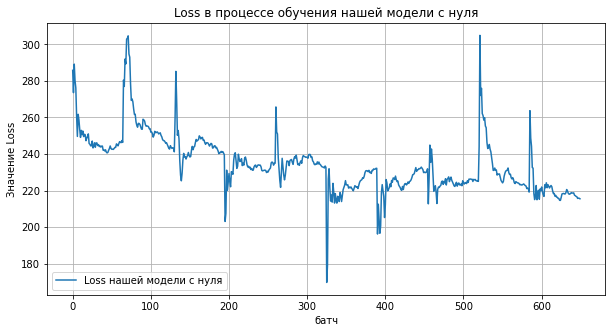

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values_my_rnn_1, label='Loss нашей модели с нуля')
plt.title('Loss в процессе обучения нашей модели с нуля')
plt.xlabel('батч')
plt.ylabel('Значение Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()  # переводим модель в режим оценки

with torch.no_grad():  # отключаем вычисление градиентов
    mae_valid_my_rnn_1 = []
    total_mae = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        # рассчитываем MAE
        mae_val = mae(outputs, labels)
        mae_valid_my_rnn_1.append(mae_val.item())
        total_mae += mae_val.item()

    average_mae = total_mae / len(valid_loader)
    print(f"MAE нашей модели на валидационной выборке: {average_mae}")

MAE нашей модели на валидационной выборке: 11.402448654174805


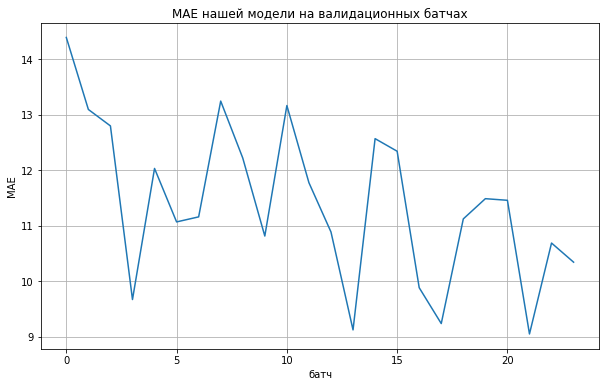

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mae_valid_my_rnn_1)
plt.title('MAE нашей модели на валидационных батчах')
plt.xlabel('батч')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

## Вывод

В ходе нашего проекта мы успешно разработали и обучили модель глубокого обучения с нуля, которая имитировала структуру ResNet-34. Модель обучалась на основе датасета, который включает 4113 изображений с метками реального возраста. По фотографии модели необходимо было определить возраст человека, который изображён на фото. Используя эту модель, **мы достигли значения средней абсолютной ошибки MAE 11,4 на валидационной выборке**, что свидетельствует о том, что наша модель способна обучаться и имеет неплохой потенциал.<br/>
<br/>
Но несмотря на достигнутые успехи, наша модель все еще не может соперничать с предварительно обученной моделью ResNet-34, обученной на большом и разнообразном наборе данных ImageNet. Это говорит о том, что большой и разнообразный набор данных для предварительного обучения может быть критически важным аспектом для достижения высоких результатов в задачах глубокого обучения.
**Но хочется отметить, что наш проект является значительным шагом вперед в понимании и применении сложных архитектур нейросетей, таких как ResNet. Мы доказали, что можем создать и обучить такую модель с нуля, и эта работа создает основу для дальнейшего улучшения и оптимизации.** <br/>
<br/>
В ходе тестирования различных гиперпараметров обучения, таких как learning rate, размер батча, выбор оптимизатора, мы пришли к выводу, что увеличение learning rate и уменьшение размера батча приводит к ухудшению качества модели, что проявляется в увеличении средней абсолютной ошибки MAE на валидационной выборке - она увеличилась до 12,8.<br/>
В дальнейшем мы могли бы рассмотреть возможность использования других стратегий для улучшения производительности нашей модели, включая более тонкую настройку гиперпараметров, использование различных методов аугментации данных, применения более сложной архитектуры нейросети.